# <div align="center">Apartment Market Analysis</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kamingyip/">Kaming Yip</a>&emsp;&emsp;GitHub: <a href = "https://github.com/KamingYip">https://github.com/KamingYip</a>&emsp;&emsp;Date: Mar. 17, 2021</div>

### Task 1

<b>Scrape the available apartments within 2 miles around Boston University which have 4 or 5-star review scores in <a href = "https://www.apartments.com/off-campus-housing/ma/boston/boston-university/">apartments.com</a>, analyze the apartment market against different room types, and predict the price trend in 2021.</b>

First, we import the required modules for scraping the property data from apartments.com and set up the targeted URL link and the user agent which includes the type of device, operating system, and browser that we will use when sending the requests to scrape and parse the website.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from random import uniform
import os
# pip install geopy
import geopy.distance
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
base_url = "https://www.apartments.com/off-campus-housing/ma/boston/boston-university/"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36"
}

A typical page of search results in apartments.com is shown below:

<img src="https://github.com/KamingYip/Apartment_Market_Analysis/blob/main/apartments.com%20Result%20Page.png?raw=true" width="800" height="400" align="center" />

We would like to extract the detailed property information in the placard section at the right hand side, as well as the available listing units in each property location if we click into the specific property pages.

<img src="https://github.com/KamingYip/Apartment_Market_Analysis/blob/main/Property%20Detail%20Page.png?raw=true" width="800" height="400" align="center" />


The total search-result page number should be extracted before we scrape through each page.

In [3]:
response = requests.get(base_url, headers = headers)
content = response.content
soup = BeautifulSoup(content, "html.parser")

page_text = soup.find("p", {"class": "searchResults"}).find("span", {"class": "pageRange"}).get_text(strip = True)
page_num = int(re.sub("[^0-9of]", "", page_text).split("of")[1])
print("Total Page Number:", page_num)

Total Page Number: 28


Typically, we will scrape the descriptive information of each property at the search-result pages, including property title, address, URL, contact number, special information, update frequency, etc. For each specific property page, we can get more detailed and important information on the available listings. Specially, we are interested in the review rating of the specific property, the geographical location, how many units and what room types are listed, and the rent of each unit.

In [4]:
column_list = ["Title", "Address", "Neighborhood", "City", "County", "ZipCode", "Rating", "URL", "Latitude", "Longitude",
               "Distance", "Latest_Updated", "Contact", "Has_Special", "Special_Detail", "Availability", "Room_Type",
               "sqft", "Bedroom", "Bathroom", "Price_Range", "Price_Min", "Price_Max", "Price_Avg", "Deposit"]

# Boston University's geographic location 
BU_coords = (42.35055870768713, -71.10537047385236)

web_content_list = []

start_time = time.time()
# Start to scrape through each result page
for page_number in range(1, page_num+1):
    
    # Introduce random sleep time in between pages to prevent overloading on the server 
    time.sleep(uniform(0, 2))
    
    # To form the URL based on the page number, focus on the rating of 4 and 5 stars
    url = base_url + str(page_number) + "/?rt4,5"
    r = requests.get(url, headers = headers)
    c = r.content
    soup = BeautifulSoup(c, "html.parser")
    
    # To extract the placard header section and the content section
    placard_header = soup.find_all("header", {"class": "placard-header"})
    placard_content = soup.find_all("section", {"class": "placard-content"})
    
    if (placard_header is not None) and (placard_content is not None):
        for item_header, item_content in zip(placard_header, placard_content):
            
            # Temporarily store each record into a dictionary
            web_content_dict = {}
            
            ele = item_header.find("span", {"class": "js-placardTitle title"})
            if ele is not None:
                web_content_dict["Title"] = ele.get_text(strip = True)
            
            ele = item_header.find("div", {"class": "property-address js-url"})
            if ele is not None:
                web_content_dict["Address"] = ele.get_text(strip = True)
            
            ele = item_content.find("div", {"class": "property-details-wrapper has-header has-specials"})
            if ele is not None:
                web_content_dict["Has_Special"] = "Yes"
                ele = ele.find("span", {"class": "specialOfferTooltip"})
                web_content_dict["Special_Detail"] = ele.get_text(strip = True)
            else:
                web_content_dict["Has_Special"] = "No"
                web_content_dict["Special_Detail"] = ""
            
            ele = item_content.find("span", {"class": "listingFreshness"})
            if ele is not None:
                web_content_dict["Latest_Updated"] = ele.get_text(strip = True)
                
            ele = item_content.find("div", {"class": "phone-wrapper"})
            if ele is not None:
                web_content_dict["Contact"] = ele.get_text(strip = True)
            
            # Move into the specific property pages
            ele = item_header.find("a", {"class": "property-link"})
            if ele is not None:
                ele_url = ele.get("href")
                web_content_dict["URL"] = ele_url
                
                ele_r = requests.get(ele_url, headers = headers)
                ele_c = ele_r.content
                ele_soup = BeautifulSoup(ele_c, "html.parser")
                
                ele_rating = ele_soup.find("div", {"class": "averageRating"})
                if ele_rating is not None:
                    web_content_dict["Rating"] = ele_rating.get_text(strip = True)
                
                # Calculate the distance between Boston University Central and the property location based on Latitude/Longitude
                try:
                    web_content_dict["Latitude"] = ele_soup.find("meta", {"property": "place:location:latitude"}).get("content")
                    web_content_dict["Longitude"] = ele_soup.find("meta", {"property": "place:location:longitude"}).get("content")
                    property_coords = (float(web_content_dict["Latitude"]), float(web_content_dict["Longitude"]))
                    web_content_dict["Distance"] = geopy.distance.distance(BU_coords, property_coords).miles
                    ele_location = geolocator.reverse(web_content_dict["Latitude"] + "," + web_content_dict["Longitude"])
                    ele_address = ele_location.raw["address"]
                    web_content_dict["Neighborhood"] = ele_address.get("neighbourhood", "")
                    web_content_dict["City"] = ele_address.get("city", "")
                    web_content_dict["County"] = ele_address.get("county", "")
                    web_content_dict["ZipCode"] = ele_address.get("postcode").split("-")[0]
                except:
                    pass
                
                try:
                    # Scrape each unit type's detailed information
                    ele_all_units = ele_soup.find("div", {"class": "tab-section active", "data-tab-content-id": "all"})
                    ele_each_unit = ele_all_units.find_all("div", {"class": ["pricingGridItem multiFamily hasUnitGrid",
                                                                             "pricingGridItem multiFamily"]})
                    
                    for unit in ele_each_unit:
                        availability = unit.find("div", {"class": "availability"}).get_text(strip = True)
                        
                        # Only record the available unit types
                        if availability != "Not Available":
                            web_content_dict["Deposit"] = re.sub(r"[^0-9.–-]", "",
                                                                 unit.find("span", {"class": "detailsTextWrapper leaseDepositLabel"}).\
                                                                 contents[3].get_text(strip = True))
                            
                            # The unit type does NOT have unit grid
                            if " ".join(unit.get("class")) == "pricingGridItem multiFamily":
                                try:
                                    unit_detail = unit.find("span", {"class": "detailsTextWrapper"}).get_text(strip = True).split(",", 2)
                                    unit_detail = [re.sub("–", "-", x) for x in unit_detail]
                                    unit_detail = [re.sub("[^0-9.-]", "", x) for x in unit_detail]
                                
                                    # Studio type
                                    if unit_detail[0] == "":
                                        web_content_dict["Bedroom"] = 0
                                        web_content_dict["Bathroom"] = 1
                                        web_content_dict["Room_Type"] = "Studio"
                                    # Other room types
                                    else:
                                        web_content_dict["Bedroom"] = unit_detail[0]
                                        web_content_dict["Bathroom"] = unit_detail[1]
                                        web_content_dict["Room_Type"] = "{0} {1}".format(web_content_dict["Bedroom"], 
                                                                                         "BR" if web_content_dict["Bedroom"] == "1" else "BRs")
                                    
                                    sqft_range = unit_detail[2].split("-")
                                    sqft_range = [float(x) for x in sqft_range]
                                    web_content_dict["sqft"] = sum(sqft_range) / len(sqft_range)
                                    
                                    web_content_dict["Price_Range"] = re.sub("–", "-",
                                                                             unit.find("span", {"class": "rentLabel"}).get_text(strip = True))
                                    Price_Range = re.sub(r"[^0-9.-]", "", web_content_dict["Price_Range"]).split("-")
                                    try:
                                        Price_Range = [float(x) for x in Price_Range]
                                        if len(Price_Range) == 1:
                                            web_content_dict["Price_Min"] = Price_Range[0]
                                            web_content_dict["Price_Max"] = Price_Range[0]
                                            web_content_dict["Price_Avg"] = Price_Range[0]
                                        else:
                                            web_content_dict["Price_Min"] = Price_Range[0]
                                            web_content_dict["Price_Max"] = Price_Range[-1]
                                            web_content_dict["Price_Avg"] = sum(Price_Range) / len(Price_Range)
                                    except:
                                        pass
                                
                                    web_content_dict["Availability"] = availability
                                    
                                    # Save each listing unit into the content list only when we detect available units
                                    web_content_list.append(web_content_dict.copy())
                                    
                                except:
                                    pass
                            
                            # The unit type has unit grid
                            else:
                                each_listing = unit.find_all("li", {"class": "unitContainer js-unitContainer"})
                            
                                # Scrape each listing unit detailed information
                                for each in each_listing:
                                    try:
                                        web_content_dict["Bedroom"] = each.get("data-beds")
                                        web_content_dict["Bathroom"] = each.get("data-baths")
                                        if web_content_dict["Bedroom"] == "0":
                                            web_content_dict["Room_Type"] = "Studio"
                                        else:
                                            web_content_dict["Room_Type"] = "{0} {1}".format(web_content_dict["Bedroom"], 
                                                                                             "BR" if web_content_dict["Bedroom"] == "1" else "BRs")
                                        web_content_dict["Price_Range"] = each.find("div", {"class": "pricingColumn column"}).\
                                                                          find("span", {"class": None}).get_text(strip = True)
                                        Price_Range = re.sub(r"[^0-9.-]", "", web_content_dict["Price_Range"]).split("-")
                            
                                        try:
                                            Price_Range = [float(ele) for ele in Price_Range]
                                            if len(Price_Range) == 1:
                                                web_content_dict["Price_Min"] = Price_Range[0]
                                                web_content_dict["Price_Max"] = Price_Range[0]
                                                web_content_dict["Price_Avg"] = Price_Range[0]
                                            else:
                                                web_content_dict["Price_Min"] = Price_Range[0]
                                                web_content_dict["Price_Max"] = Price_Range[-1]
                                                web_content_dict["Price_Avg"] = sum(Price_Range) / len(Price_Range)
                                        except:
                                            pass
                                
                                        try:
                                            sqft_range = re.sub(r"[^0-9.-]", "",
                                                                each.find("div", {"class": "sqftColumn column"}).\
                                                                find("span", {"class": None}).get_text(strip = True)).\
                                                         split("-")
                                            sqft_range = [float(ele) for ele in sqft_range]
                                            web_content_dict["sqft"] = sum(sqft_range) / len(sqft_range)
                                        except:
                                            pass
                                
                                        try:
                                             web_content_dict["Availability"] = each.find("span", {"class": "dateAvailable"}).\
                                                                                contents[2].strip()
                                        except:
                                            pass
                                
                                        # Save each listing unit into the content list only when we detect available units
                                        web_content_list.append(web_content_dict.copy())
                                    except:
                                        pass
                except:
                    pass

end_time = time.time()
print("Finish scraping. Total scraping time {0:.2f} minute(s).".format((end_time - start_time)/60))

Finish scraping. Total scraping time 3.94 minute(s).


In [5]:
def imputation(df, index_list, feature):
    for i in index_list:
        df.loc[i, feature] = np.nanmedian(df.loc[df["Room_Type"] == df.loc[i, "Room_Type"], feature])

In [6]:
# Convert the content list to a pandas dataframe with the desired order of column list
property_info = pd.DataFrame(web_content_list, columns = column_list)
numeric_columns = ["Rating", "Latitude", "Longitude", "sqft", "Bedroom", "Bathroom",
                   "Price_Min", "Price_Max", "Price_Avg", "Deposit"]
property_info[numeric_columns] = property_info[numeric_columns].apply(pd.to_numeric)

# Filter the properties with review rating higher than or equal to 4.0
property_info = property_info[property_info["Rating"] >= 4.0].reset_index(drop = True)

# Filter the properties within a distance of 2.0 miles (included) to Boston University center
property_info = property_info[property_info["Distance"] <= 2.0].reset_index(drop = True)

# Handle the missing values - Imputation with median value within the same room type
try:
    price_min_index = list(property_info[property_info["Price_Min"].isnull()].index)
    imputation(property_info, price_min_index, "Price_Min")
    price_max_index = list(property_info[property_info["Price_Max"].isnull()].index)
    imputation(property_info, price_max_index, "Price_Max")
    price_avg_index = list(property_info[property_info["Price_Avg"].isnull()].index)
    imputation(property_info, price_avg_index, "Price_Avg")
except:
    pass

# Handle outliers in sqft feature - Imputation with median value within the same room type
try:
    sqft_index = list(property_info[property_info["sqft"].isin([9999, np.nan])].index)
    imputation(property_info, sqft_index, "sqft")
except:
    pass

print("Valid Results: {0:,} different properties, with {1:,} records and {2} features in total.".\
      format(len(property_info.groupby("Title")["Title"].unique()), property_info.shape[0], property_info.shape[1]),
      end = "\n\n")

# Output the dataframe to a .csv file
try:
    ticker = "Apartment_List"
    output_dir = os.getcwd()
    output_file = os.path.join(output_dir, ticker + ".csv")
    property_info.to_csv(output_file, index = False)
    print("Successfully output the {0}.csv file to the direction:\n{1}".format(ticker, output_dir))
except Exception as e:
    print(e)
    print("Failed to save the scraped data into a .csv file.")

Valid Results: 99 different properties, with 983 records and 25 features in total.

Successfully output the Apartment_List.csv file to the direction:
/Users/yipkaming


In [7]:
property_info.head(5)

,Title,Address,Neighborhood,City,County,ZipCode,Rating,URL,Latitude,Longitude,...,Availability,Room_Type,sqft,Bedroom,Bathroom,Price_Range,Price_Min,Price_Max,Price_Avg,Deposit
0,Fenway Triangle,"180 Brookline Ave, Boston, MA 02215",Audubon Square,Boston,Suffolk County,02215,4.8,https://www.apartments.com/fenway-triangle-bos...,42.34445,-71.10114,...,Contact property for availability,Studio,528.0,0,1.0,"$2,451 - $3,544",2451.0,3544.0,2997.5,NaN
1,Fenway Triangle,"180 Brookline Ave, Boston, MA 02215",Audubon Square,Boston,Suffolk County,02215,4.8,https://www.apartments.com/fenway-triangle-bos...,42.34445,-71.10114,...,Available Now,1 BR,818.0,1,1.0,"$2,643 - $4,337",2643.0,4337.0,3490.0,NaN
2,Fenway Triangle,"180 Brookline Ave, Boston, MA 02215",Audubon Square,Boston,Suffolk County,02215,4.8,https://www.apartments.com/fenway-triangle-bos...,42.34445,-71.10114,...,Available Now,2 BRs,1221.5,2,2.0,"$3,637 - $5,088",3637.0,5088.0,4362.5,NaN
3,Fenway Triangle,"180 Brookline Ave, Boston, MA 02215",Audubon Square,Boston,Suffolk County,02215,4.8,https://www.apartments.com/fenway-triangle-bos...,42.34445,-71.10114,...,Available Now,3 BRs,1588.0,3,3.0,"$6,748 - $8,821",6748.0,8821.0,7784.5,NaN
4,Van Ness,"1335 Boylston St, Boston, MA 02215",Audubon Square,Boston,Suffolk County,02215,5.0,https://www.apartments.com/van-ness-boston-ma/...,42.34462,-71.09983,...,Now,Studio,490.0,0,1.0,"$2,442",2442.0,2442.0,2442.0,NaN


As shown above, we have successfully scraped the valid apartment information which satisfies the task requirements from the website and save the desired features into a dataframe named `property_info`.

We use library <b>Folium</b> to visualize geospatial data that has been manipulated on an interactive Leaflet map, which is represented as column `Latitude` and `Longitude` in the dataset. Also, the room type of each unit is visualized as markers on the map.

In [8]:
map_samples = property_info[["Title", "Room_Type", "Latitude", "Longitude"]].dropna()
labels = list(map_samples["Title"] + "\n" + map_samples["Room_Type"])
latitudes = list(map_samples["Latitude"])
longitudes = list(map_samples["Longitude"])

BU_lat = 42.35055870768713
BU_lon = -71.10537047385236

In [9]:
density_map = folium.Map(location = [BU_lat, BU_lon], zoom_start = 13)

Room_Type = MarkerCluster().add_to(density_map)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
        location = [lat, lng],
        icon = None,
        popup = label
    ).add_to(Room_Type)

folium.Marker(location = [BU_lat, BU_lon], popup = "Boston University",
              icon = folium.Icon(color = "white", icon_color = "red", icon = "university", prefix = "fa")
             ).add_to(density_map)

density_map

As displayed in the map, the available properties and units are generally distributed in Fenway, Cambridge, Allston, and Brookline, which are the cloest neighborhoods around BU.

Fenway is one of the most dynamic neighborhood around. Historic and packed with colleges, Fenway is one of the top choices for students. The neighborhood is home to baseball's iconic Fenway Park, student hangouts and buzzy restaurants are concentrated around Kenmore Square, and clubs and sports bars line Lansdowne Street.

Cambridge, nestled along the Charles River, is home to both Harvard University and the Massachusetts Institute of Technology (MIT), two world-class universities that are located just two miles from one another. This one-of-a-kind college town stands as a historical, cultural, and education hub for the state of MA.

Allston is known for its rising student population due to its proximity to Harvard Business School, Boston College, and Boston University, and as a K-town with a ton of trendy bars, multicultural restaurants, and cool music venues.

Brookline, where I used to live in the past 2 years, a lively and bustling suburb close to the downtown Boston, is in a classic Bostonian style. The neighborhood offers a great mix of quite, idyllic area with the ease of access to modern entertainment venues and delightful dining options.

In [10]:
df_avail = property_info[["Has_Special", "Availability"]].copy()
df_avail["Ava"] = df_avail["Availability"].str[0:3]
df_avail.loc[df_avail["Ava"].isin(["Ava", "Soo", "Con", "Mar"]), "Ava"] = "Now"

ava_columns = ["Now", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"]
special_by_avail = df_avail.groupby(["Ava", "Has_Special"]).size().\
                   unstack(fill_value = 0).reindex(index = ava_columns, columns = ["Yes", "No"])
special_by_avail

Has_Special,Yes,No
Ava,,
Now,453,239
Apr,48,34
May,32,38
Jun,26,40
Jul,12,9
Aug,6,21
Sep,10,14
Oct,0,1


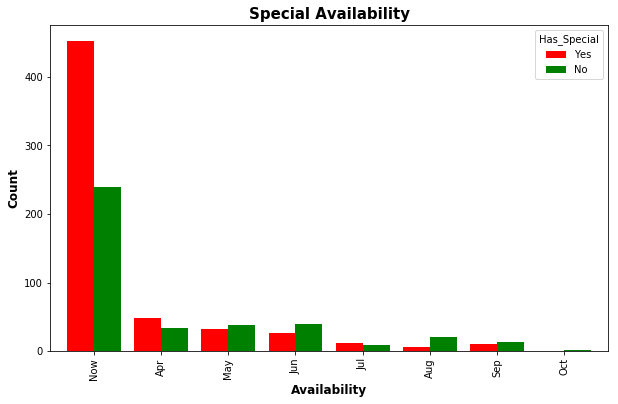

In [11]:
ax1 = special_by_avail.plot(kind = "bar", color = ["red", "green"], width = 0.8, figsize = (10, 6))
ax1.set_title("Special Availability", fontsize = 15, fontweight = "bold")
ax1.set_xlabel("Availability", fontsize = 12, fontweight = "bold")
ax1.set_ylabel("Count", fontsize = 12, fontweight = "bold")
plt.show()

Apparently, as we check the availability of apartments in the dataset, it's a virtual certainty that the real estate companies have more available units that are already open to the market than they will have in the following few months, while as time goes on, there are fewer availabilities for sure. Additionally, it's shown that approximately 2 ouf of 3 of the available apartments offer move-in special promotions (e.g. 2 months free) to attract potential residents, which is a common strategy for the real estate companies to apply especially during the downturn periods.

In [12]:
room_columns = ["Studio", "1 BR", "2 BRs", "3 BRs", "4 BRs"]

df_room = property_info[["Availability", "Room_Type", "sqft", "Price_Avg", "Deposit"]].copy()
df_room["Ava"] = df_room["Availability"].str[0:3]
df_room.loc[df_room["Ava"].isin(["Ava", "Soo", "Con", "Mar"]), "Ava"] = "Now"

stats_by_room = df_room.groupby("Room_Type")["sqft", "Price_Avg", "Deposit"].\
                agg([("Count", np.size), ("Median", np.median), ("Max", np.max),
                     ("Min", np.min), ("Avg", np.nanmean), ("Std", np.std)]).\
                fillna(0).reindex(index = room_columns).astype(int)
stats_by_room

sqft                               Price_Avg                      \
          Count Median   Max   Min   Avg  Std     Count Median    Max   Min   
Room_Type                                                                     
Studio      215    504   757   198   476  112       215   2405   3450  1200   
1 BR        382    694  1057   357   696  133       382   2845   4738  1575   
2 BRs       328   1000  1451   448   996  185       328   3427   6810  1700   
3 BRs        49   1200  2200   587  1249  324        49   4065  14087  2875   
4 BRs         9   1258  1526  1100  1272  116         9   4900   5400  3264   

                      Deposit                                 
            Avg   Std   Count Median    Max  Min   Avg   Std  
Room_Type                                                     
Studio     2437   544     215    500  21580  100   780  2146  
1 BR       2911   681     382    500   3500  100   887   699  
2 BRs      3622   939     328    750   3900  500  1121   872  
3 BRs      4716  2066      49   1000   3400  100  1155  1068  
4 BRs      4578   701       9      0      0    0     0     0

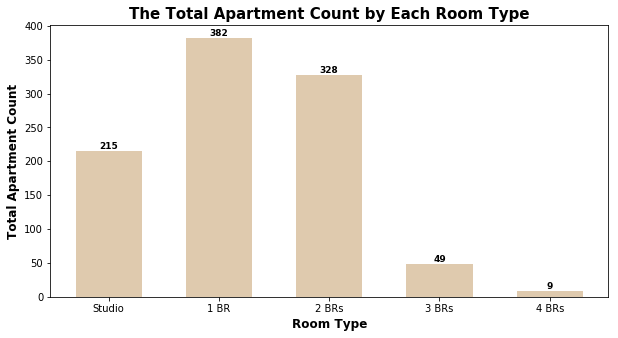

In [13]:
plt.figure(figsize = (10, 5))
f2 = plt.bar(stats_by_room.index, stats_by_room["sqft"]["Count"], align = "center",
             alpha = 0.7, color = "tan", width = 0.6)
plt.title("The Total Apartment Count by Each Room Type", fontsize = 15, fontweight='bold')
plt.xlabel("Room Type", fontsize = 12, fontweight='bold')
plt.ylabel("Total Apartment Count", fontsize = 12, fontweight='bold')
plt.axis('tight')
for i in f2:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, height, height.astype(int), ha = "center", va = "bottom",
             fontsize = 9, fontweight='bold')
plt.show()

As indicated in the bar plot above, 1 Bedroom apartment has the highest vacancy (i.e. 382 listed) among all the room types, while 4 Bedrooms apartment has the lowest (i.e. only 9 listed). However, this figure can only demonstrate the vacancy, instead of the vacancy rate, among the current listing; there could be far fewer 4-Bedroom apartments than 1-Bedroom built around the selected area. In other words, without further research, we are ineligible to come to the conclusion that which type of room is the most popular one around.

However, we can still get a general sense of the vacancy situation among the high-rated apartments within the area. For the rental apartment market, it's revealed that the competition in 1 Bedroom and 2 Bedrooms types is fierce, with an abundance of openings. For the real estate companies, the leasing teams are suggested to be well aware of the current conditions, analyze the rent roll, and promote appropriate speical offers, as discussed above, to vitalize the market.

In [14]:
def add_hist(df, room_type, feature, color):
    plt.hist(df.loc[df["Room_Type"] == room_type, feature],
             label = "{0}: N = {1}, μ = {2} sqft, σ = {3} sqft".\
                        format(room_type,
                               stats_by_room.loc[room_type, feature]["Count"],
                               stats_by_room.loc[room_type, feature]["Avg"],
                               stats_by_room.loc[room_type, feature]["Std"]),
             density = False, alpha = 0.5, color = color)

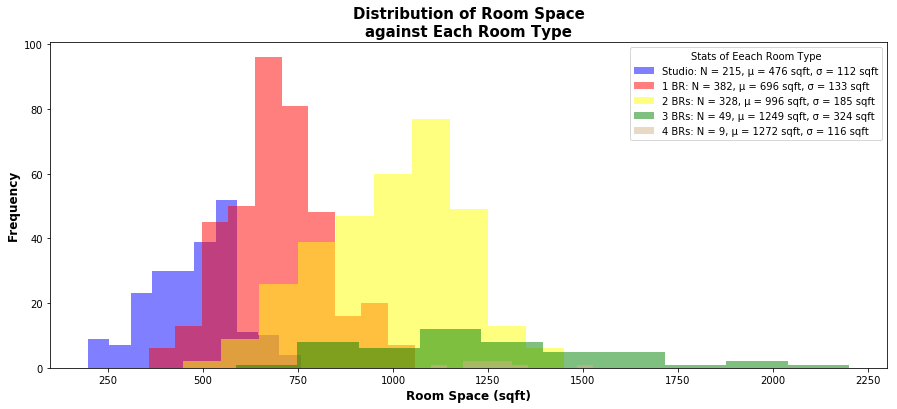

In [15]:
color_list = ["blue", "red", "yellow", "green", "tan"]
f3 = plt.figure(figsize = (15, 6))
ax3 = f3.add_subplot(111)

for room_type, color in zip(room_columns, color_list):
    add_hist(df_room, room_type, "sqft", color)

plt.title("Distribution of Room Space\nagainst Each Room Type", fontsize = 15, fontweight='bold')
plt.xlabel("Room Space (sqft)", fontsize = 12, fontweight='bold')
plt.ylabel("Frequency", fontsize = 12, fontweight='bold')
plt.legend(title = "Stats of Eeach Room Type")
plt.show()

As shown in the statistic table as well as the frequency histogram, the more bedrooms a apartment has, the larger the apartment will be in room space, which is consistent with our common sense. Also, the room space can have larger variance when the apartment has more bedrooms.

Take Studio and 1 Bedroom types of apartments as an example. The Studio type of apartments around Boston University have an average room space of 475 sq. ft. with a standard deviation of 112 sq. ft, while the 1-Bedroom type of apartments have a room space of 696 sq. ft. on average with a standard deviation of 133 sq. ft. Certainly, the room space feature could be useful when a potential resident compares between the different apartments and makes a more cost-efficient decision.

For the rent price feature, the situation gets a bit more complicated since the listing apartments can be separated into different groups of availability (e.g. now, April, May) and the rent of each room type should not be compared between different available periods. That being said, we need to separate the entire dataset by different availabilities and analyze the rent only for the properties within the same group.

In [16]:
def q95(x):
    return x.quantile(0.95)

multi_index = pd.MultiIndex.from_product([room_columns, ava_columns])
rent_by_avail = df_room.groupby(["Room_Type", "Ava"])["Price_Avg"].\
                agg([("Vacancy", np.size), ("Median", np.nanmedian), ("Max", np.max),
                     ("Min", np.min), ("Avg", np.nanmean), ("Std", np.nanstd), ("95%", q95)]).\
                reindex(index = multi_index).fillna(0).astype(int)
rent_by_avail = rent_by_avail[rent_by_avail["Vacancy"] != 0]
print(" " * 5 + "* Statistic Summary for Price Average *")
rent_by_avail

     * Statistic Summary for Price Average *


Vacancy  Median    Max   Min   Avg   Std   95%
Studio Now      143    2598   3450  1200  2507   592  3304
       Apr       14    2364   2866  1358  2236   447  2799
       May       12    2325   2827  1595  2243   393  2717
       Jun       15    2455   2836  1595  2425   312  2835
       Jul        3    2190   3035  1495  2240   771  2950
       Aug       21    2200   3200  1800  2376   411  3200
       Sep        7    2055   2400  1595  2059   242  2340
1 BR   Now      271    2845   4738  1575  2965   743  4299
       Apr       42    2956   3690  1800  2873   449  3527
       May       34    2672   3613  1925  2679   451  3323
       Jun       25    2894   4075  1600  2828   558  3438
       Jul        6    2512   2850  2250  2546   202  2807
       Aug        1    3575   3575  3575  3575     0  3575
       Sep        3    2450   2465  2180  2365   160  2463
2 BRs  Now      232    3357   6810  1700  3632  1043  5738
       Apr       23    4059   4660  2900  3953   487  4592
       May       23    3999   4945  2910  3861   585  4694
       Jun       22    3487   4538  2350  3434   598  4174
       Jul       12    3562   4350  2900  3527   417  4174
       Aug        5    2900   3450  1850  2800   582  3340
       Sep       10    3150   3500  1900  3042   479  3488
       Oct        1    3450   3450  3450  3450     0  3450
3 BRs  Now       39    4065  14087  2875  4774  2280  9051
       Apr        3    3700   6070  3595  4455  1399  5832
       May        1    5199   5199  5199  5199     0  5199
       Jun        4    4769   5245  3875  4664   679  5241
       Sep        2    3850   4000  3700  3850   212  3985
4 BRs  Now        7    5000   5400  3264  4687   771  5355
       Sep        2    4200   4200  4200  4200     0  4200

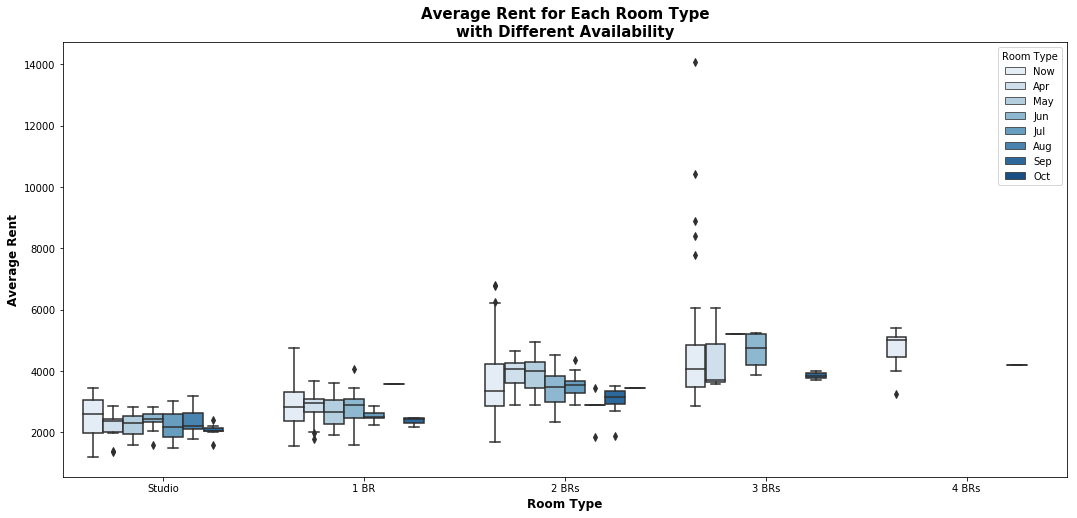

In [17]:
plt.subplots(figsize = (18, 8))
sns.boxplot(y = "Price_Avg", x = "Room_Type", data = df_room, palette = "Blues", hue = "Ava", hue_order = ava_columns)
plt.title("Average Rent for Each Room Type\nwith Different Availability", fontsize = 15, fontweight = "bold")
plt.xlabel("Room Type", fontsize = 12, fontweight = "bold")
plt.ylabel("Average Rent", fontsize = 12, fontweight = "bold")
plt.legend(title = "Room Type")
plt.show()

As demonstrated in the statistic summary, if a customer is looking for a readily move-in apartment recently, the average high-rated-apartment rent around Boston University is \\$2,517 for a Studio, \\$2,965 for 1 Bedroom, \\$3,620 for 2 Bedrooms, \\$4,753 for 3 Bedrooms, and \\$4,687 for 4 Bedrooms, without regard to the special promotions given by the individual companies.

Interestingly, we can see the average rent price fluctuates through the different periods and it has slightly different patterns between each room type. For Studio type, the average price gradually decreases by each month and the difference between each unit could be unstable during the time. However, the problem, which also occurs in the other room types, is that there are only a few available openings for the following seasons listed on the website, and without enough data points, we are too early to draw any solid conclusions on the near future market. 

Surprisingly, 1 Bedroom and 2 Bedrooms markets display a upward tendency as shown in the rent. Although with eye-catching variation, the average rent generally remains the similar level, even with a slight rise in the following months. As metioned in the previous section, we've learnt that these two markets are greatly competitive since the available openings (supply) have obviously exceeded the demand in the market. That being said, on one hand, with public health metrics continuing to trend in a positive direction, the market prices are expected to rise as the state has now advanced to Step 2 of Phase III of the reopening plan this month and continued to reopen the economy; on the other hand, the leasing teams design appealing promotions intending to stimulate the apartment market's vitality. This could also explain why some of the apartments listed for the peak season (e.g. summer time) are offering outstanding price to encourage potential customers to sign a lease with a early-bird price.

In conclusion, based on the current listing, the rent in the following few months is predicted to remain the same level, yet small fluctuations are also unavoidable. However, this does not necessarily suggest that the real estate companies can lay down and relax after the bleakest of times. Instead, they should focus more closely on the industry and market, as well as the reopening policy. As getting closer to the summer time, it's reasonble to predict that a slight climb could be highly possible as the demand for apartments is predicted to increase.

### Task 2

<b>Taking the analysis of the first task as the background, suppose there is a small apartment in this area with 10 4B3B units. The current rent roll of this apartment can be found in <a href = "https://github.com/KamingYip/Apartment_Market_Analysis/blob/main/rent_roll-20210114(1).csv">here</a>. Our company is considering taking this apartment, while we need to predict the rent price and vacancy and provide the landlord with a quotation.

Please make a simple proposal, supporting by resonable diagrams and operation models, for the landlord based on the aforementioned information.

Tips: you can first calculate the cash flow brought by the current rent roll. Given a rental pace, a full rent can be reached after a certain period of time, which can be 2 months in this case. Then, the revenue can be calculated based on the predicted price and vacancy rate. Additionally, as an operator, the company needs to undertake the operating costs, while still hopes to have a net margin of about 5%.

The contents of the proposal should include the lease term and the monthly rent paid to the landlord. A rent-free period of about 2 months at the beginning is accepted. Proposal can be leased for 3-5 years.</b>

In [18]:
import calendar

Let's first download the rent roll dataset and save it to a dataframe.

In [19]:
rent_roll = pd.read_csv(
    "https://github.com/KamingYip/Apartment_Market_Analysis/blob/main/rent_roll-20210114(1).csv?raw=true"
)

print("Original Dataset Shape: {0} rows, {1} columns".format(rent_roll.shape[0], rent_roll.shape[1]))
rent_roll = rent_roll.loc[2: , ~rent_roll.columns.isin(["Tags", "BD/BA", "Sq. Ft.", "Market Rent","Deposit",
                                                        "Move-out", "NSF Count", "Late Count", "Past Due"])].\
            reset_index(drop = True)
print("Modified Dataset Shape: {0} rows, {1} columns".format(rent_roll.shape[0], rent_roll.shape[1]))

rent_roll["Rent"] = pd.to_numeric(rent_roll["Rent"].str.replace(",", ""))
rent_roll.loc[rent_roll["Rent"] == 0.0, "Rent"] = np.nan
rent_roll["Lease From"] = pd.to_datetime(rent_roll["Lease From"])
rent_roll["Lease To"] = pd.to_datetime(rent_roll["Lease To"])
rent_roll.head()

Original Dataset Shape: 42 rows, 14 columns
Modified Dataset Shape: 40 rows, 5 columns


,Unit,Status,Rent,Lease From,Lease To
0,Unit 107 - Rm 1,Vacant-Unrented,NaN,NaT,NaT
1,Unit 107 - Rm 2,Vacant-Unrented,NaN,NaT,NaT
2,Unit 107 - Rm 3,Vacant-Unrented,NaN,NaT,NaT
3,Unit 107 - Rm 4,Vacant-Unrented,NaN,NaT,NaT
4,Unit 203 - Rm 1,Vacant-Rented,1258.0,2021-03-01,2021-06-30


Let's first plot the distribution of the current rent to get a general sense of the apartment.

/Users/yipkaming/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yipkaming/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


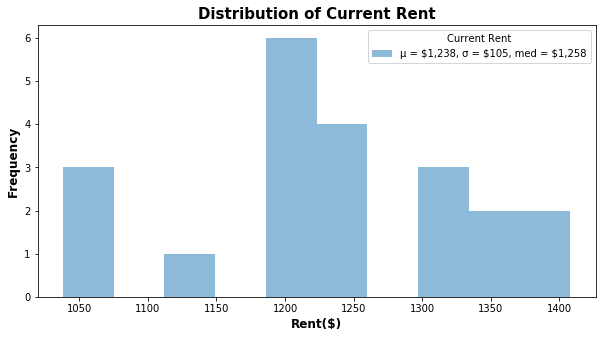

In [20]:
f4 = plt.figure(figsize = (10, 5))
ax4 = f4.add_subplot(111)

plt.hist(rent_roll["Rent"], density = False, alpha = 0.5,
         label = "μ = ${0:,.0f}, σ = ${1:,.0f}, med = ${2:,.0f}".\
                 format(np.nanmean(rent_roll["Rent"]), np.nanstd(rent_roll["Rent"]), np.nanmedian(rent_roll["Rent"])))

plt.title("Distribution of Current Rent", fontsize = 15, fontweight='bold')
plt.xlabel("Rent($)", fontsize = 12, fontweight='bold')
plt.ylabel("Frequency", fontsize = 12, fontweight='bold')
plt.legend(title = "Current Rent")
plt.show()

As displayed in the histogram, the current rent has an average of \\$1,238, with a standard deviation of \\$105, while the median of rent is \\$1,258. The rent is generally within two standard deviation, and the average and median values are in the same level.

In [21]:
rent_diff = rent_by_avail["Avg"].unstack().reindex(index = room_columns, columns = ava_columns)

ori_columns = rent_diff.columns
new_columns = []
for i, ele in enumerate(ori_columns):
    try:
        new_columns.append(ele)
        new_columns.append("{0}_Diff_{1}(%)".format(ele, ori_columns[i+1]))
        rent_diff["{0}_Diff_{1}(%)".format(ele, ori_columns[i+1])] = \
            round(100*(rent_diff[ori_columns[i+1]] - rent_diff[ele]) / rent_diff[ele], 2)
    except:
        pass

rent_diff = pd.DataFrame(rent_diff, columns = new_columns)
rent_diff

,Now,Now_Diff_Apr(%),Apr,Apr_Diff_May(%),May,May_Diff_Jun(%),Jun,Jun_Diff_Jul(%),Jul,Jul_Diff_Aug(%),Aug,Aug_Diff_Sep(%),Sep,Sep_Diff_Oct(%),Oct
Studio,2507.0,-10.81,2236.0,0.31,2243.0,8.11,2425.0,-7.63,2240.0,6.07,2376.0,-13.34,2059.0,NaN,NaN
1 BR,2965.0,-3.10,2873.0,-6.75,2679.0,5.56,2828.0,-9.97,2546.0,40.42,3575.0,-33.85,2365.0,NaN,NaN
2 BRs,3632.0,8.84,3953.0,-2.33,3861.0,-11.06,3434.0,2.71,3527.0,-20.61,2800.0,8.64,3042.0,13.41,3450.0
3 BRs,4774.0,-6.68,4455.0,16.70,5199.0,-10.29,4664.0,NaN,NaN,NaN,NaN,NaN,3850.0,NaN,NaN
4 BRs,4687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4200.0,NaN,NaN


Based on the statistic summary from Task 1, we've learnt that there are no clear or consistent patterns detected in the rent price and it generally fluctuates within ±10% between each month. Since we barely have data for 4 Bedrooms type of apartments listed, we will mainly take the current rent roll as a base, assuming that the new rent will follow a normal distribution with a mean of <b>\\$1,238</b> and a standard deviation of <b>\\$105</b>. Taking the peak season (let's say <b>July - September</b>) into consideration, the average rent during this period will have a 10% rise (i.e. <b>\\$1,362</b>) and the standard deviation level remains the same.

In [22]:
normal_vacancy_count = rent_roll["Rent"].isnull().sum()
normal_vacancy_rate = round(rent_roll["Rent"].isnull().sum() / len(rent_roll), 4)
print("Among the {0} bedrooms, there are {1} of them are vacant and unrented, which is a {2:.2f}% vacancy rate.".\
      format(len(rent_roll), normal_vacancy_count,
             100 * normal_vacancy_rate))

Among the 40 bedrooms, there are 19 of them are vacant and unrented, which is a 47.50% vacancy rate.


As calculated, the current vacancy rate of the apartment is 47.50% when handled by the landlord. We will assume that the vacancy rate will <b>remain the same level</b> during the following few months and will decline to <b>25.00%</b> when it comes to the peak time.

Another important assumpation has been made in this case is that the new leases will only have <b>6-month</b> or <b>12-month term</b>. It is assumed that a new resident is allowed to randomly choose 6-month lease or 12-month lease with an equal probability (i.e. 50% vs 50%). We also assume that there is no difference between different bedrooms, which allows us to equally generate random rent for each available opening and assign the rent to the new leases.

In [23]:
normal_mean = np.nanmean(rent_roll["Rent"])
std = np.nanstd(rent_roll["Rent"])

peak_season = ["Jul", "Aug", "Sep"]
peak_mean = round(normal_mean * 1.1)
peak_vacancy_rate = 0.25
peak_vacancy_count = int(len(rent_roll) * peak_vacancy_rate)

current_yr = 2021
current_month = 3
lease_end_yr = 2024

new_term_choices = [6, 12]

In [24]:
def revenue_predict(df, normal_mean, std, peak_mean, peak_season, normal_vacancy_count, peak_vacancy_count,\
                    current_yr, current_month, lease_end_yr, new_term_choices, random_seed):
    np.random.seed(random_seed)
    normal_random_rent = list(np.random.normal(loc = normal_mean, scale = std, size = 200).astype(int))
    np.random.seed(random_seed+1)
    peak_random_rent = list(np.random.normal(loc = peak_mean, scale = std, size = 200).astype(int))
    np.random.seed(random_seed+2)
    new_term = list(np.random.choice(a = new_term_choices, size = 500, replace = True))
    
    rent_list = list(df["Rent"])
    unit_list = list(df["Unit"])
    period_list = list(((df["Lease To"].dt.year - current_yr) * 12 + \
                        (df["Lease To"].dt.month - current_month + 1)).astype("Int32"))
    time_list = ["{0}_{1}".format(yr, month) for yr in range (current_yr, lease_end_yr+1)\
                                             for month in list(calendar.month_abbr)[1:]][current_month-1:]
    
    cash_flow_dict = {}
    
    for month in time_list:
        vacancy_indices = [i for i, ele in enumerate(rent_list) if str(ele) == "nan"]
        current_vacancy_count = len(vacancy_indices)
        if current_vacancy_count != 0:
            # if it is in peak season
            if month[-3:] in peak_season:
                if current_vacancy_count > peak_vacancy_count:
                    indices = vacancy_indices[ : (current_vacancy_count - peak_vacancy_count)]
                    for i in indices:
                        rent_list[i] = peak_random_rent.pop(0)
                        period_list[i] = new_term.pop(0)
        
            # if it is in normal season
            else:
                if current_vacancy_count > normal_vacancy_count:
                    indices = vacancy_indices[ : (current_vacancy_count - normal_vacancy_count)]
                    for i in indices:
                        rent_list[i] = normal_random_rent.pop(0)
                        period_list[i] = new_term.pop(0)
        
        # record the rents for current month 
        cash_flow_dict[month] = rent_list
    
        period_list = [x - 1 for x in period_list]
        period_list = [ele if ele != 0 else np.nan for ele in period_list]
        rent_list = [ele if str(period_list[i]) != "nan" else np.nan for i, ele in enumerate(rent_list)]     
        
    cash_flow = pd.DataFrame(cash_flow_dict, index = unit_list).astype("Int32")
    cash_flow.loc["Monthly Revenue"] = cash_flow.sum()
    cash_flow.loc["Vacancy Rate(%)"] = round(100 * (cash_flow.isnull().sum()) / len(cash_flow), 2)
    
    return cash_flow

In [25]:
current_cash_flow = revenue_predict(rent_roll, normal_mean, std, peak_mean, peak_season, normal_vacancy_count, peak_vacancy_count,\
                                    current_yr, current_month, lease_end_yr, new_term_choices, 0)
current_cash_flow

,2021_Mar,2021_Apr,2021_May,2021_Jun,2021_Jul,2021_Aug,2021_Sep,2021_Oct,2021_Nov,2021_Dec,...,2024_Mar,2024_Apr,2024_May,2024_Jun,2024_Jul,2024_Aug,2024_Sep,2024_Oct,2024_Nov,2024_Dec
Unit 107 - Rm 1,NaN,1422,1422,1422,1422,1422,1422,NaN,NaN,NaN,...,1270,1270,1270,1270,1148,1148,1148,1148,1148,1148
Unit 107 - Rm 2,NaN,1279,1279,1279,1279,1279,1279,1279,1279,1279,...,1147,1147,1147,1147,1328,1328,1328,1328,1328,1328
Unit 107 - Rm 3,NaN,NaN,NaN,NaN,1531,1531,1531,1531,1531,1531,...,1323,1323,1323,1323,1448,1448,1448,1448,1448,1448
Unit 107 - Rm 4,NaN,NaN,NaN,NaN,1296,1296,1296,1296,1296,1296,...,1240,1240,1240,1240,1385,1385,1385,1385,1385,1385
Unit 203 - Rm 1,1258,1258,1258,1258,1305,1305,1305,1305,1305,1305,...,1476,1476,1476,1476,1476,1324,1324,1324,1324,1324
Unit 203 - Rm 2,1198,1198,1198,1198,1248,1248,1248,1248,1248,1248,...,969,969,969,969,969,969,969,969,969,969
Unit 203 - Rm 3,NaN,NaN,NaN,NaN,1451,1451,1451,1451,1451,1451,...,1084,1084,1084,1084,1084,1365,1365,1365,1365,1365
Unit 203 - Rm 4,NaN,NaN,NaN,NaN,1119,1119,1119,1119,1119,1119,...,1306,1306,1306,1306,1441,1441,1441,1441,1441,1441
Unit 206 - Rm 1,1408,1408,1408,1408,1544,1544,1544,1544,1544,1544,...,1242,1242,1242,1242,1242,1242,1242,1242,1242,1242
Unit 206 - Rm 2,1348,1348,1348,1348,1280,1280,1280,1280,1280,1280,...,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328


In [26]:
def revenue_plot(df, title_str):
    fig, ax1 = plt.subplots(figsize = (18, 6))
    
    line1 = ax1.plot(df.loc["Monthly Revenue"], color = "red", marker = "o", label = "Monthly Revenue")
    ax1.set_xlabel("Month", fontsize = 12, fontweight='bold')
    ax1.set_ylabel("Monthly Revenue($)", color = "red", fontsize = 12, fontweight='bold')
    ax1.set_xticklabels(df.columns, rotation = 90)

    ax2 = ax1.twinx()
    line2 = ax2.plot(df.loc["Vacancy Rate(%)"], color = "blue", marker = "o", label = "Vacancy Rate(%)")
    ax2.set_ylabel("Vacancy Rate(%)", color = "blue", fontsize = 12, fontweight='bold')

    lines = line1 + line2
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc = 1)

    plt.title("Monthly Performance by {0} Rent Roll".format(title_str), fontsize = 15, fontweight='bold')
    plt.show()

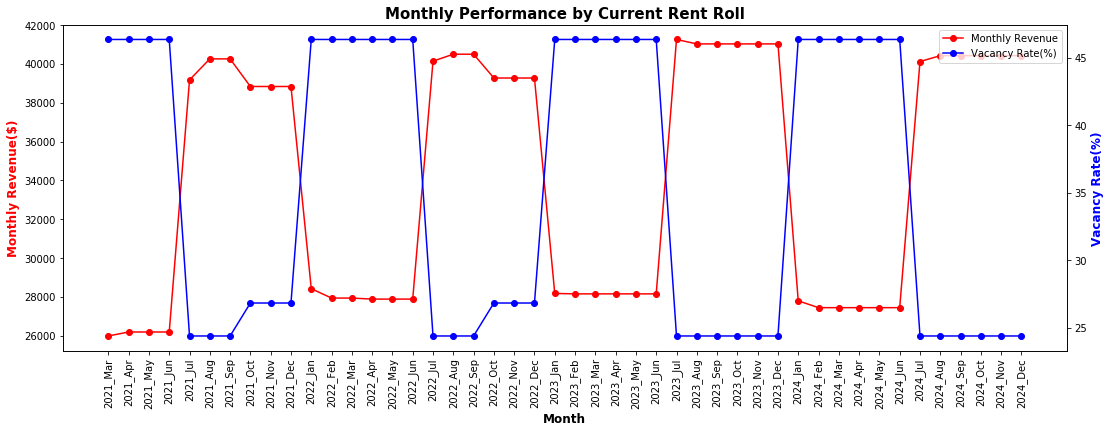

In [27]:
revenue_plot(current_cash_flow, "Current")

As indicated from the cash flow table and the line graph, with all the aforementioned assumptions that have been made, the monthly revenue follow a clear pattern that it constantly swings between the peaks and bottoms. To be more specific, under the specific conditions, the first half of a year will be a low tide period and the second half will be busier and more profitable.

However, since we have introduced normal distribution in the simulation, we should also consider the possible bias and noise incurred by this setting. Therefore, Monte Carlo method is applied in this simulation. Monte Carlo method is a computational algorithm that relies on repeated random sampling to obtain results; in other words, we will calculate the results over and over, each time using a different set of random values (e.g. normal rent, peak rent, lease term). The reason why we will use Monte Carlo method is to minimize the impact of noise and uncertainty in the simulation, especially when we generate rents and lease terms with certain probability distribution.

In this instance, we assign the trial size as 1,000.

In [28]:
sim_size = 1000
np.random.seed(0)
seed_list = np.random.randint(sim_size, size = sim_size)

current_avg_monthly_revenue = []
for seed in seed_list:
    cash_flow = revenue_predict(rent_roll, normal_mean, std, peak_mean, peak_season, normal_vacancy_count, peak_vacancy_count,\
                                current_yr, current_month, lease_end_yr, new_term_choices, seed)
    current_avg_monthly_revenue.append(np.mean(cash_flow.loc["Monthly Revenue"]))

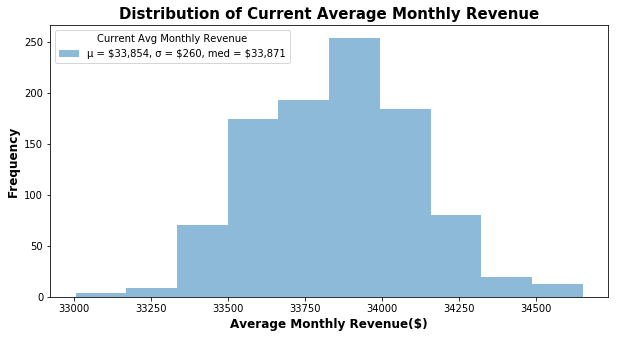

In [29]:
f5 = plt.figure(figsize = (10, 5))
ax5 = f5.add_subplot(111)

plt.hist(current_avg_monthly_revenue, density = False, alpha = 0.5,
         label = "μ = ${0:,.0f}, σ = ${1:,.0f}, med = ${2:,.0f}".\
                 format(np.mean(current_avg_monthly_revenue), np.std(current_avg_monthly_revenue),
                        np.nanmedian(current_avg_monthly_revenue)))

plt.title("Distribution of Current Average Monthly Revenue", fontsize = 15, fontweight='bold')
plt.xlabel("Average Monthly Revenue($)", fontsize = 12, fontweight='bold')
plt.ylabel("Frequency", fontsize = 12, fontweight='bold')
plt.legend(title = "Current Avg Monthly Revenue")
plt.show()

As decribed above, we assume the vacancy rate will generally remain 47.50% during the normal time and will go down to 25.00% during the peak time. Within the time period (i.e. from Mar. 2021 to Dec. 2024, in total 46 months), the average monthly revenue for the landlord will be:

In [30]:
current_avg = np.mean(current_avg_monthly_revenue)
print("Current Average Monthly Revenue: ${0:,.0f}".format(current_avg))

Current Average Monthly Revenue: $33,854


On the other hand, if we dig into the scraped data and filter the 4 Bedrooms units, we can find that the listed 9 units are within 4BR2BA, 4BR1.5BA, and 4BR1BA type. It's reasonable to set a higher price for our 4BR3BA units, taking the extra space and the extra bathroom into consideration. If we take the median price (i.e. \\$5,000 in total) for the entire unit, which gives an average of <b>\\$1,250</b> for renting a single bedroom (compared to \\$1,238), we will still come up with an attractive price for renting.

In [31]:
Bed4 = property_info.loc[property_info["Bedroom"] == 4, ["Title", "Room_Type", "Bedroom", "Bathroom", "Price_Avg"]]
Bed4

,Title,Room_Type,Bedroom,Bathroom,Price_Avg
696,Longwood Row,4 BRs,4,2.0,4900.0
697,Longwood Row,4 BRs,4,2.0,5250.0
698,Longwood Row,4 BRs,4,3.0,5400.0
743,120 Columbia St,4 BRs,4,2.0,5000.0
744,120 Columbia St,4 BRs,4,2.0,5000.0
781,The Cantabrigia,4 BRs,4,1.0,3264.0
847,Freeman-St Paul Apartments,4 BRs,4,1.5,4200.0
848,Freeman-St Paul Apartments,4 BRs,4,1.5,4200.0
937,1 Darling Apartments - NO FEE - Available 9/1,4 BRs,4,2.0,3995.0


Specially, if the company undertakes the apartment from the landlord, we assume that the occupancy rate will stay in full rent (i.e. <b>100%</b>) during the peak seasons and even remain <b>90%</b> in the normal periods. Similarly, the average rent price will have a 10% rise if a customer signs the lease during the peak seasons (i.e. \\$1,375 per month). Additionally, the standard deviation will be the same as the previous one. The lease term with the landlord will remain the same and the lease term with the residents will also include 6-month and 12-month choices. Again, we will implement Monte Carlo method to calculate the results.

In [32]:
normal_mean_new = 1250
std_new = std
normal_vacancy_rate_new = 0.1
normal_vacancy_count_new = int(normal_vacancy_rate_new * len(rent_roll))

peak_mean_new = round(normal_mean_new * 1.1)
peak_vacancy_rate_new = 0
peak_vacancy_count_new = 0

current_yr = 2021
current_month = 3
lease_end_yr = 2024

new_term_choices = [6, 12]

In [33]:
np.random.seed(1)
seed_list = np.random.randint(sim_size, size = sim_size)

new_avg_monthly_revenue = []
for seed in seed_list:
    cash_flow = revenue_predict(rent_roll, normal_mean_new, std_new, peak_mean_new, peak_season,
                                normal_vacancy_count_new, peak_vacancy_count_new, current_yr, current_month,
                                lease_end_yr, new_term_choices, seed)
    new_avg_monthly_revenue.append(np.mean(cash_flow.loc["Monthly Revenue"]))

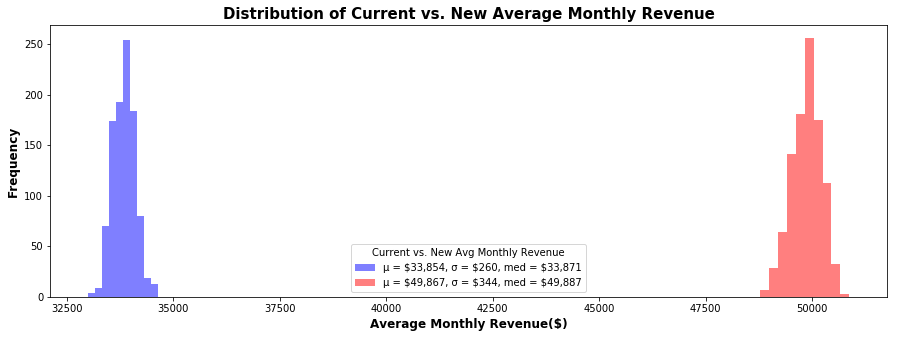

In [34]:
f6 = plt.figure(figsize = (15, 5))
ax6 = f6.add_subplot(111)

plt.hist(current_avg_monthly_revenue, density = False, alpha = 0.5, color = "blue",
         label = "μ = ${0:,.0f}, σ = ${1:,.0f}, med = ${2:,.0f}".\
                 format(np.mean(current_avg_monthly_revenue), np.std(current_avg_monthly_revenue),
                        np.nanmedian(current_avg_monthly_revenue)))

plt.hist(new_avg_monthly_revenue, density = False, alpha = 0.5, color = "red",
         label = "μ = ${0:,.0f}, σ = ${1:,.0f}, med = ${2:,.0f}".\
                 format(np.mean(new_avg_monthly_revenue), np.std(new_avg_monthly_revenue),
                        np.nanmedian(new_avg_monthly_revenue)))

plt.title("Distribution of Current vs. New Average Monthly Revenue", fontsize = 15, fontweight='bold')
plt.xlabel("Average Monthly Revenue($)", fontsize = 12, fontweight='bold')
plt.ylabel("Frequency", fontsize = 12, fontweight='bold')
plt.legend(title = "Current vs. New Avg Monthly Revenue")
plt.show()

Interestingly, the monthly performance of revenue and vacancy rate remains the similar patterns with the previous setting. However, we can apparently learn that the monthly revenue greatly exceeds the current rent roll, as well as better performance in vacancy rate. Specifically, we generate an average monthly revenue of:

In [35]:
new_avg = np.mean(new_avg_monthly_revenue)
print("New Average Monthly Revenue: ${0:,.0f}".format(new_avg))

New Average Monthly Revenue: $49,867


However, this number isn't the final number that can be used to discuss our profit. As designed, since more expenses incurs in labor, marketing, as well as operation and adminitration, we will assume that these expenses will be up to <b>(1)10%</b> or <b>(2)15%</b> of the total revenue. In this setting, if the company would like a <b>5% net margin</b>, which will be:

In [36]:
net_margin = 0.05
cost_perc = [0.1, 0.15]
for i, cost in enumerate(cost_perc):
    print("Setting {0}: operational cost percent = {1:.2f}%".format(i, cost * 100),
          "",
          "Plan 1: Current Rent Roll",
          "Current Average Monthly Revenue: ${0:,.0f}".format(current_avg),
          "",
          "Plan 2: Company Take Over the Property",
          "New Average Monthly Revenue: ${0:,.0f}".format(new_avg),
          "Monthly Cost({0:.2f}%): ${1:,.0f}".format(cost * 100, new_avg * cost),
          "Monthly Net Margin: ${0:,.0f}".format(new_avg * net_margin),
          "Monthly Profit: ${0:,.0f}".format(new_avg * (1 - cost - net_margin)),
          "",
          "Monthly Difference between two plans: ${0:,.0f}, {1:.2f}% of the original plan".\
          format(new_avg * (1 - cost - net_margin) - current_avg,
                 100*(new_avg * (1 - cost - net_margin) - current_avg)/current_avg),
          sep = "\n", end = "\n" + "-"*70 + "\n\n")

Setting 0: operational cost percent = 10.00%

Plan 1: Current Rent Roll
Current Average Monthly Revenue: $33,854

Plan 2: Company Take Over the Property
New Average Monthly Revenue: $49,867
Monthly Cost(10.00%): $4,987
Monthly Net Margin: $2,493
Monthly Profit: $42,387

Monthly Difference between two plans: $8,533, 25.21% of the original plan
----------------------------------------------------------------------

Setting 1: operational cost percent = 15.00%

Plan 1: Current Rent Roll
Current Average Monthly Revenue: $33,854

Plan 2: Company Take Over the Property
New Average Monthly Revenue: $49,867
Monthly Cost(15.00%): $7,480
Monthly Net Margin: $2,493
Monthly Profit: $39,894

Monthly Difference between two plans: $6,040, 17.84% of the original plan
----------------------------------------------------------------------



That being said, by handing over the apartment project to our company with a 46-month lease term, the landlord can receive an extra profit of more than 25%, which is \\$8,533 on average for each month, when we have a total operational cost as 10.00% of the total revenue; while the extra average monthly profit for the landlord will be \\$6,040 when the operational cost is 15.00% of the total revenue.